# Background model building

Using nbextensions is nice: https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html
`conda install -c conda-forge jupyter_contrib_nbextensions`

In [1]:
import os
import sys
import numpy as np
import pathlib
import shutil
import importlib
from tqdm import tqdm
import copy

if os.getcwd().endswith('inspects'):
    os.chdir("..")
    print(f"CWD changed to: {os.getcwd()}.")

from inspects.utils import *
add_root_to_path(steps_up=2)

CWD changed to: D:\Fafa\Emelki\Code\See.


## Setup paths

In [2]:
import vendor
import cv2

input_root = pick_path([r"tests\input"])
office_dataset = pick_path([r"tests\input\office"])

## Prepare samples

In [3]:
import vendor.SEP.sep.loaders.images as loaders
import vendor.SEP.sep._commons.visuals as visuals
importlib.reload(loaders)

def annotatation_matcher(image_path : pathlib.Path):
    image_name = image_path.stem.replace("in", "gt") + ".png"
    return str(image_path.parent.parent / "masks" / image_name)

office_loader = loaders.ImagesLoader(data_root=os.path.join(office_dataset, "images"), 
                                     annotation_for_image_finder=annotatation_matcher,
                                     verbose=0)

print(office_loader)
print("Data count:", len(office_loader))

ImageLoader for: tests\input\office\images
Data count: 12


image_sample <class 'imageio.core.util.Array'>
Shape: (240, 360, 3), Type: uint8, Min-max: (0, 255), Mean: 96.71096450617284
gt_sample <class 'imageio.core.util.Array'>
Shape: (240, 360), Type: uint8, Min-max: (0, 255), Mean: 10.690914351851852


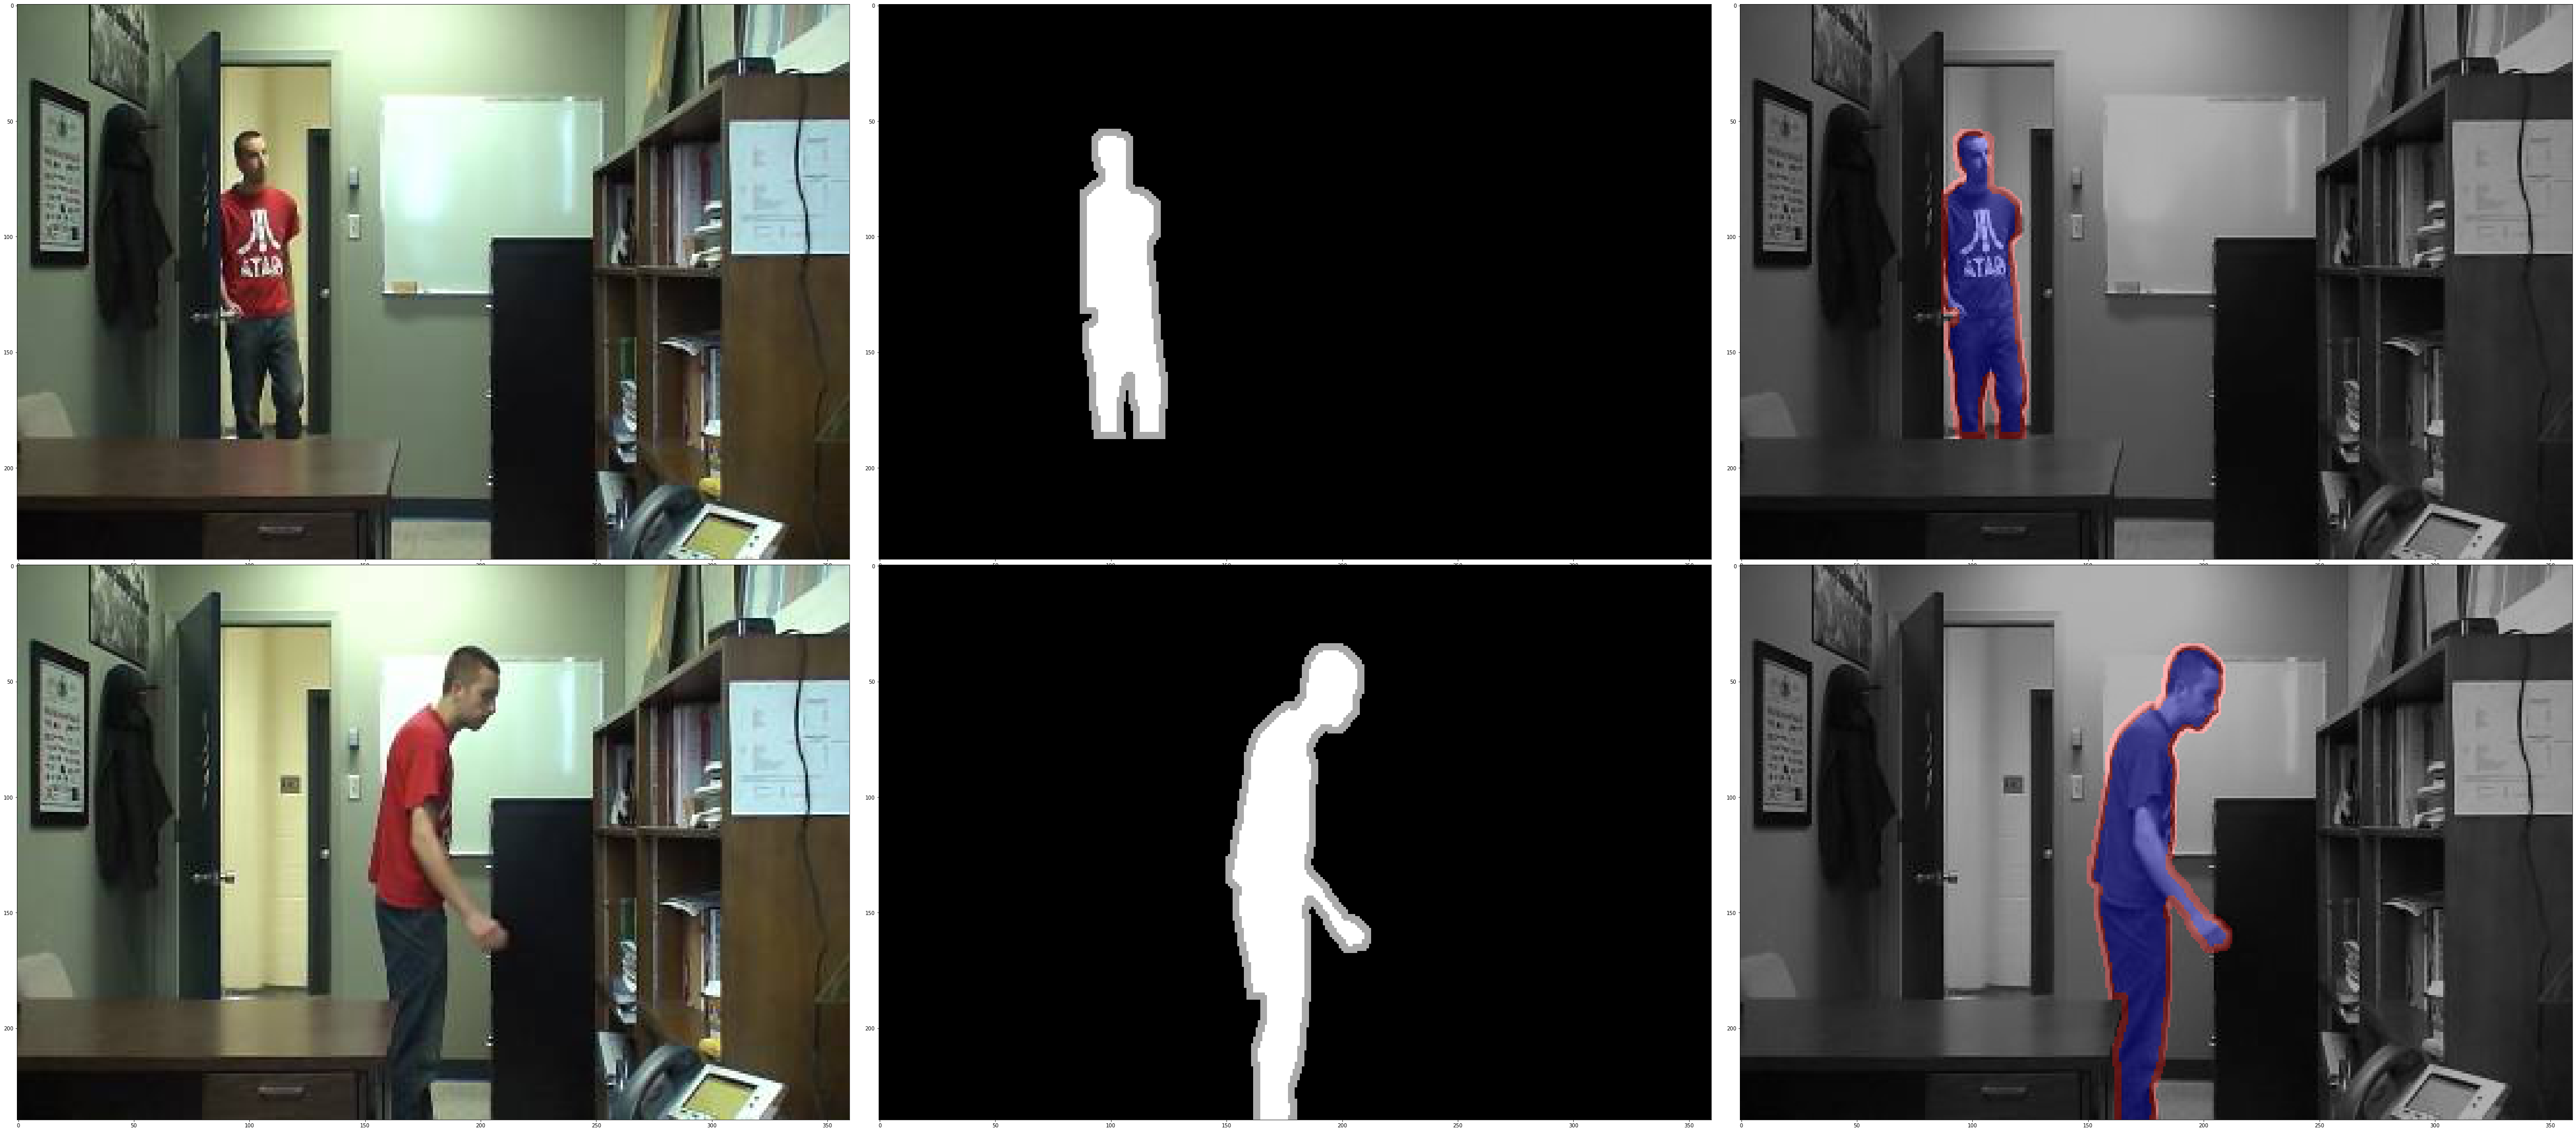

In [4]:
image_sample_1 = office_loader.load_image(0)
gt_sample_1 = office_loader.load_annotation(0)

image_sample_5 = office_loader.load_image(5)
gt_sample_5 = office_loader.load_annotation(5)

info(image_sample_1, "image_sample")
info(gt_sample_1, "gt_sample")

show_all(2, 3, image_sample_1, gt_sample_1, visuals.overlay(image_sample_1, gt_sample_1),
               image_sample_5, gt_sample_5, visuals.overlay(image_sample_5, gt_sample_5));

## Background difference

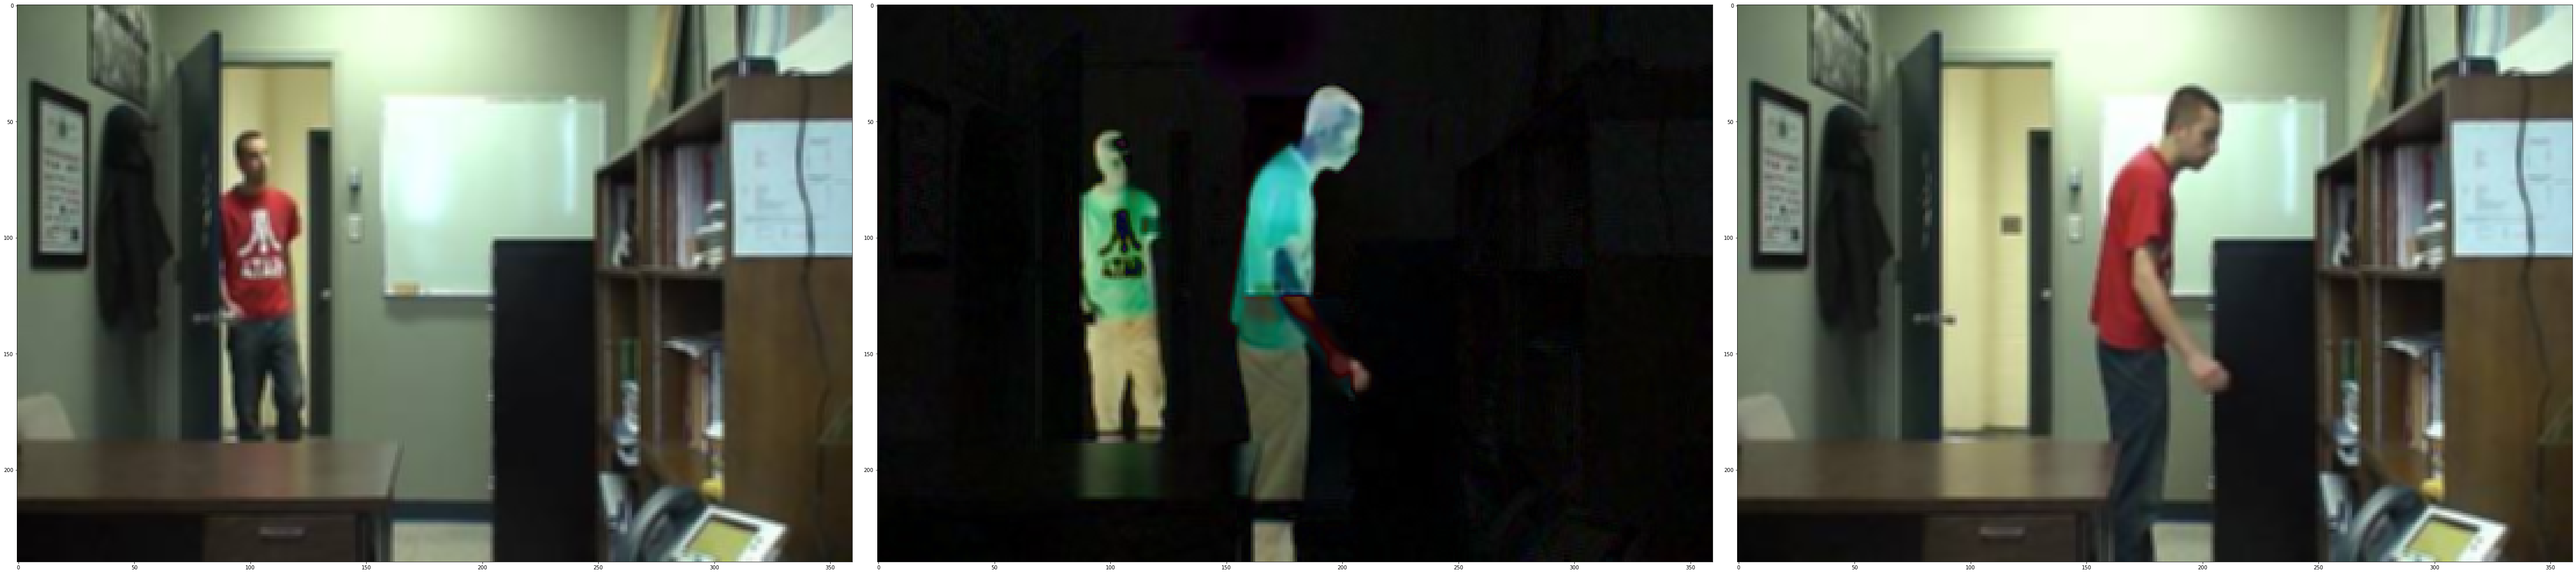

In [5]:
img1_blur = cv2.blur(image_sample_1, (3,3))
img5_blur = cv2.blur(image_sample_5, (3,3))
diff = cv2.absdiff(img1_blur, img5_blur)
show(img1_blur, diff, img5_blur)

## Building background

In [19]:
from see.foreground.backgrounds import StaticBackgroundModel
model = StaticBackgroundModel(update_inertia=3.0, error_inertia=3.0, diff_method='rgb')

In [20]:
def update_for_frame(model, nr):
    image_sample = office_loader.load_image(nr)
    gt_sample = office_loader.load_annotation(nr)
    background_mask = gt_sample == 0
    model.update(image_sample, background_mask)

update_for_frame(model, 0)

background_error <class 'imageio.core.util.Array'>
Shape: (240, 360), Type: float64, Min-max: (0.0, 1.0), Mean: 0.9535648148148148


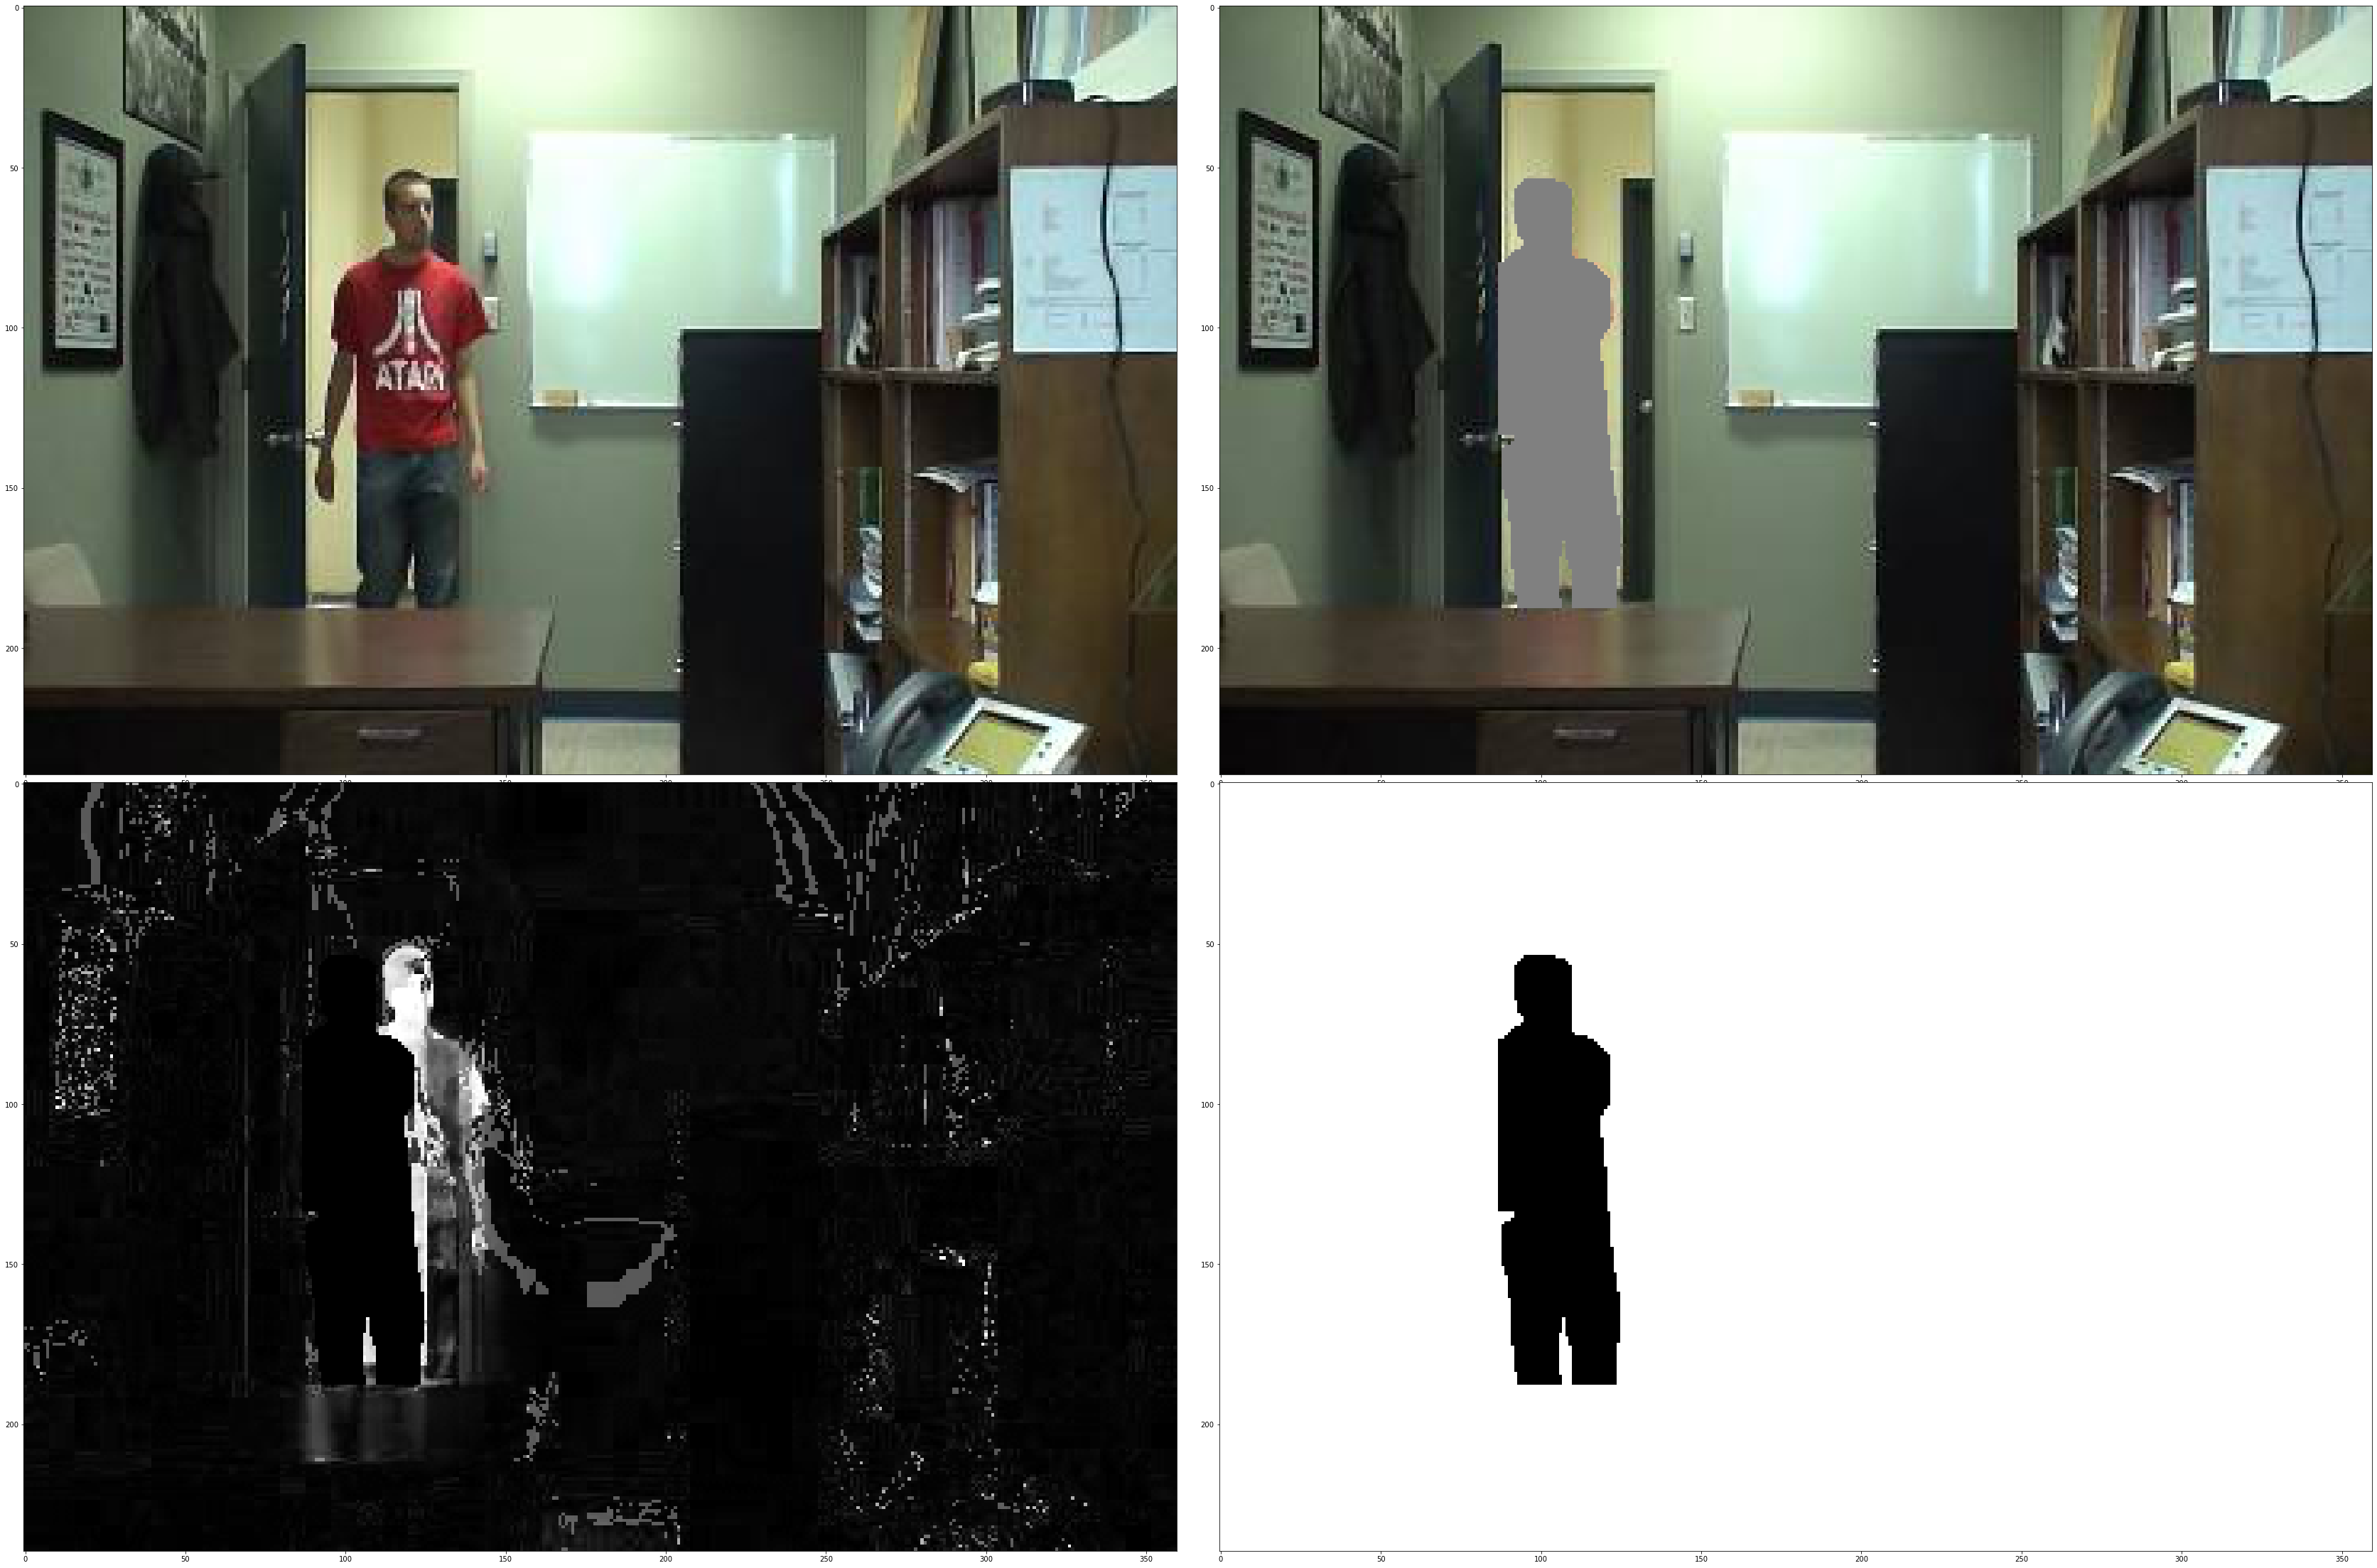

In [21]:
def show_model_for_frame(model, nr):
    image_sample = office_loader.load_image(nr)
    current_background =  model.get()
    model_state = model.get_details()
    background_diff = model.calc_diff(image_sample, current_background)
    model_state['error'] = model_state['error'] * model_state['mask']
    background_diff = background_diff * model_state['mask']
    info(model_state['error'], "background_error")
    show_all(2, 2, image_sample, current_background.astype(np.uint8), background_diff, model_state['error'])
    
show_model_for_frame(model, 1)

background_error <class 'imageio.core.util.Array'>
Shape: (240, 360), Type: float64, Min-max: (0.0, 32.5), Mean: 1.6745447530864197


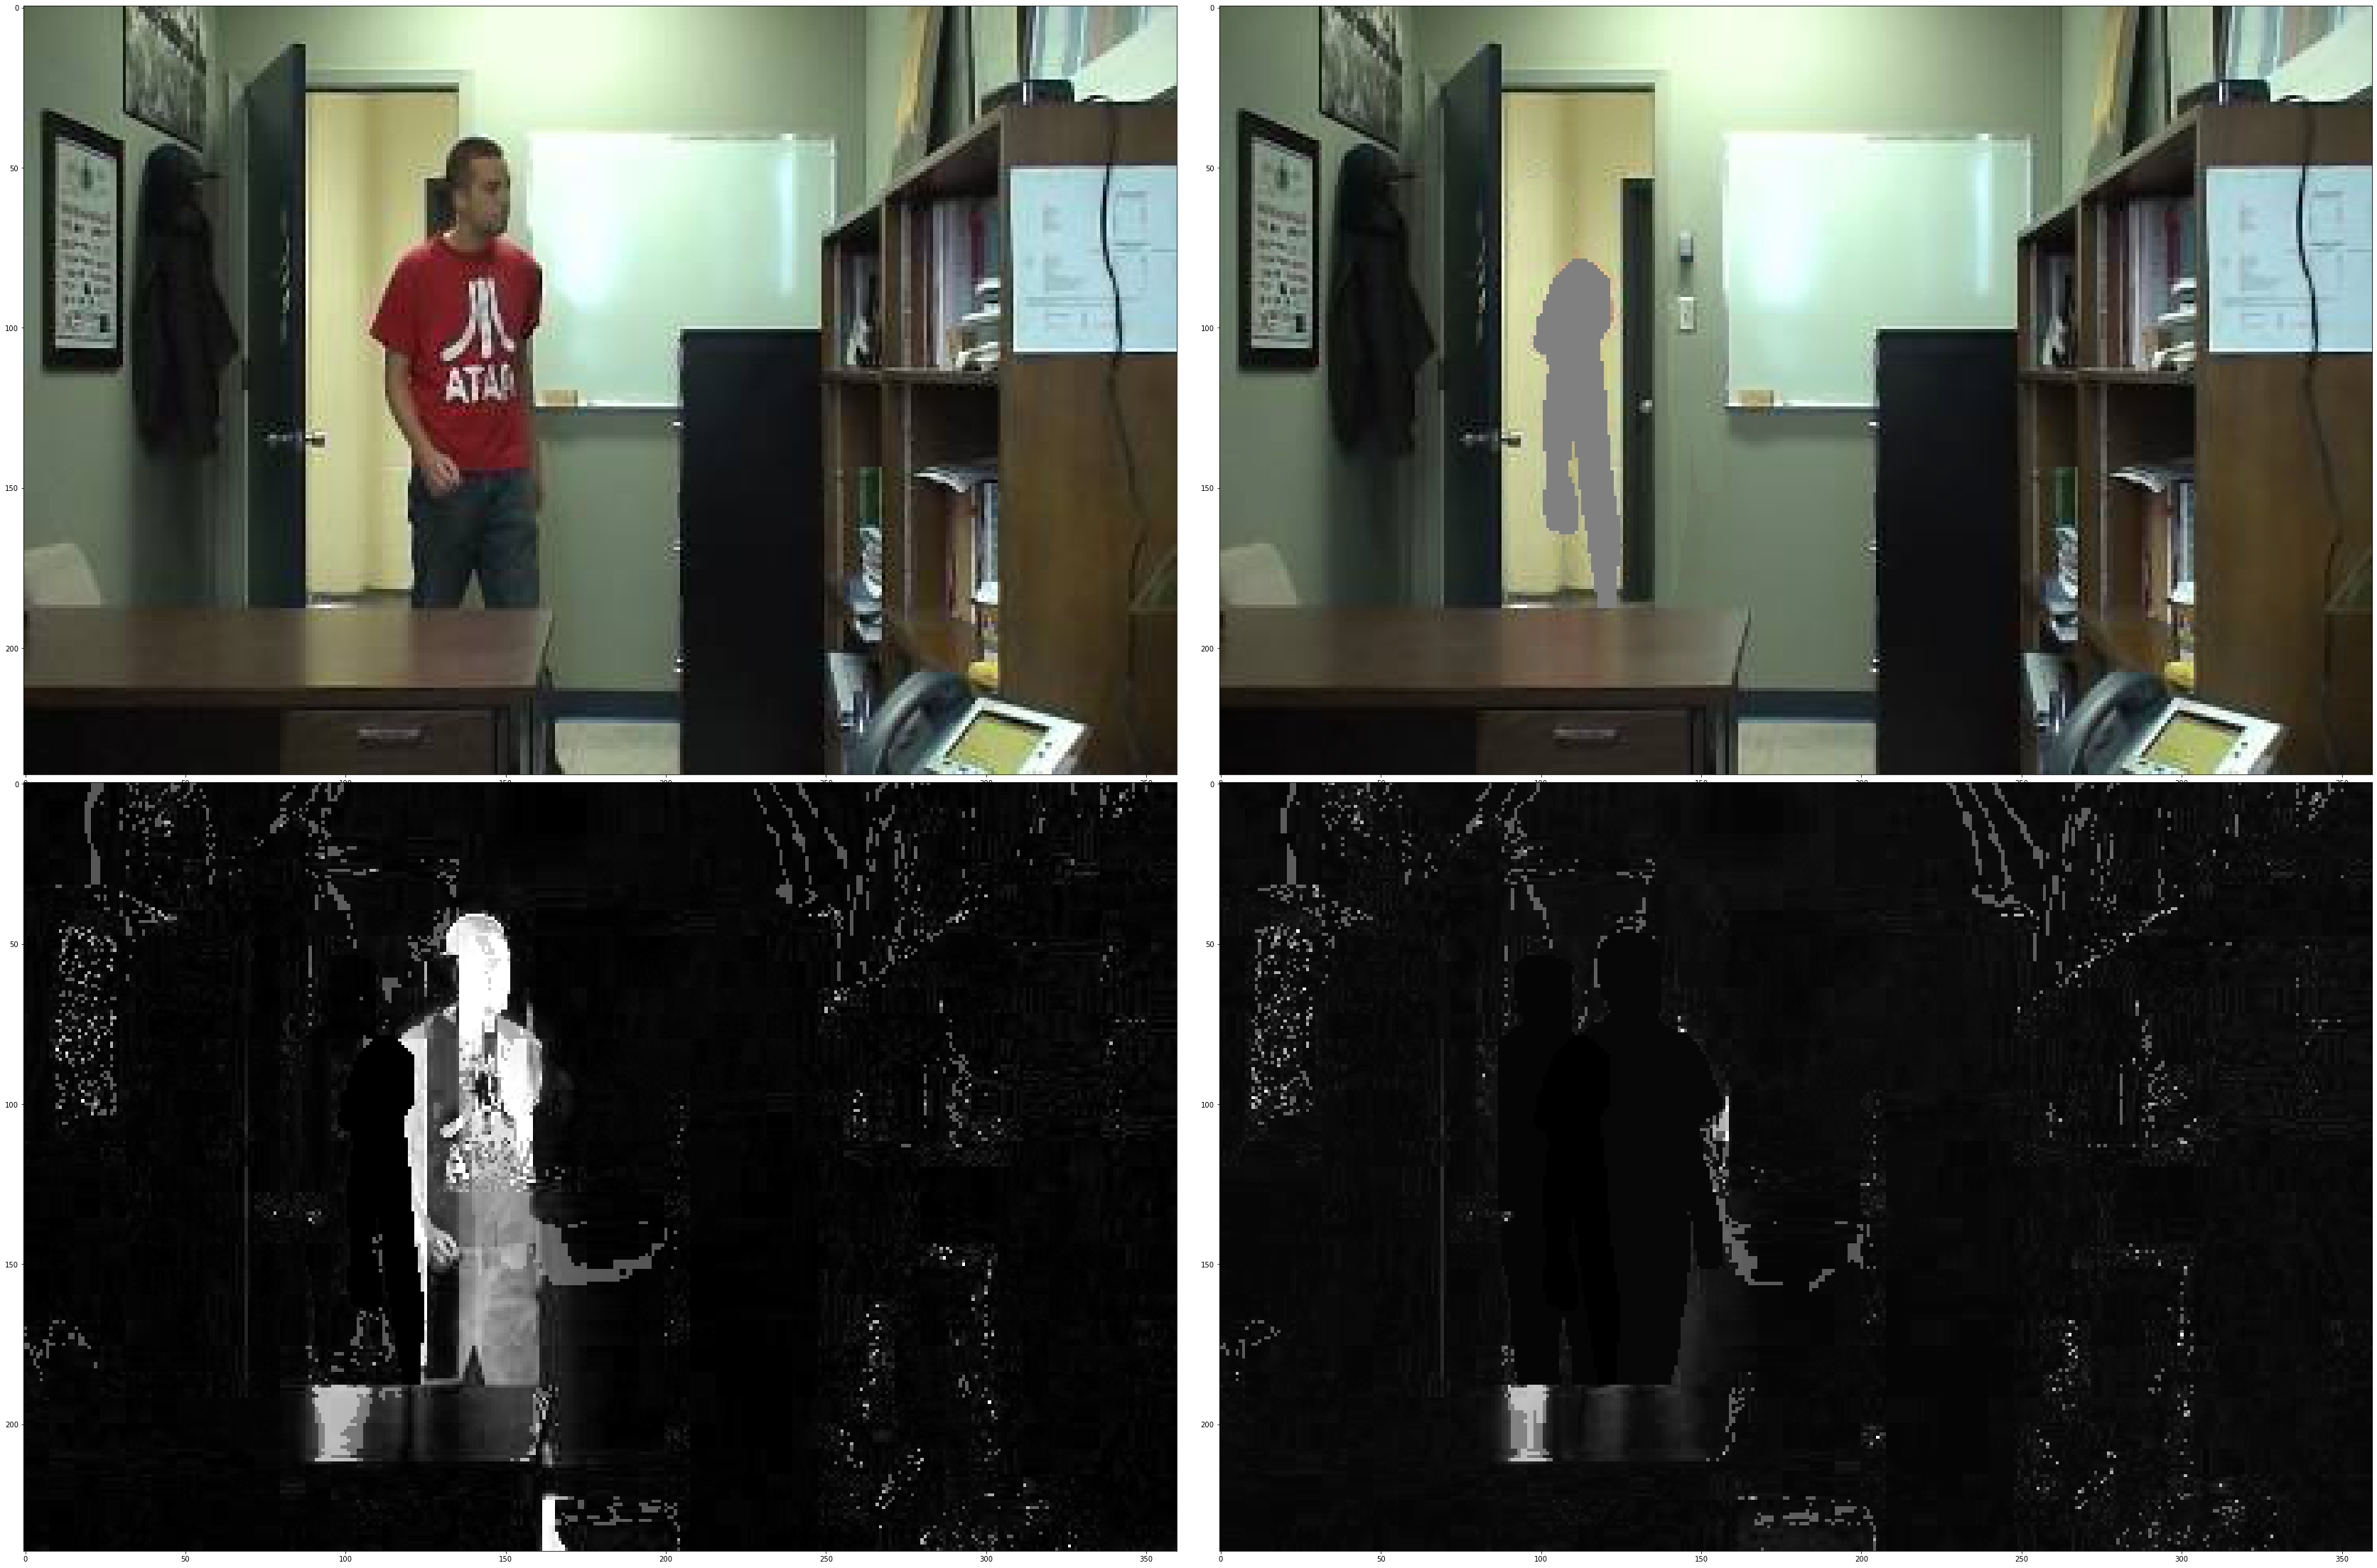

In [22]:
update_for_frame(model, 2)
show_model_for_frame(model, 3)

background_error <class 'imageio.core.util.Array'>
Shape: (240, 360), Type: float64, Min-max: (0.0, 48.75), Mean: 2.811189477237655


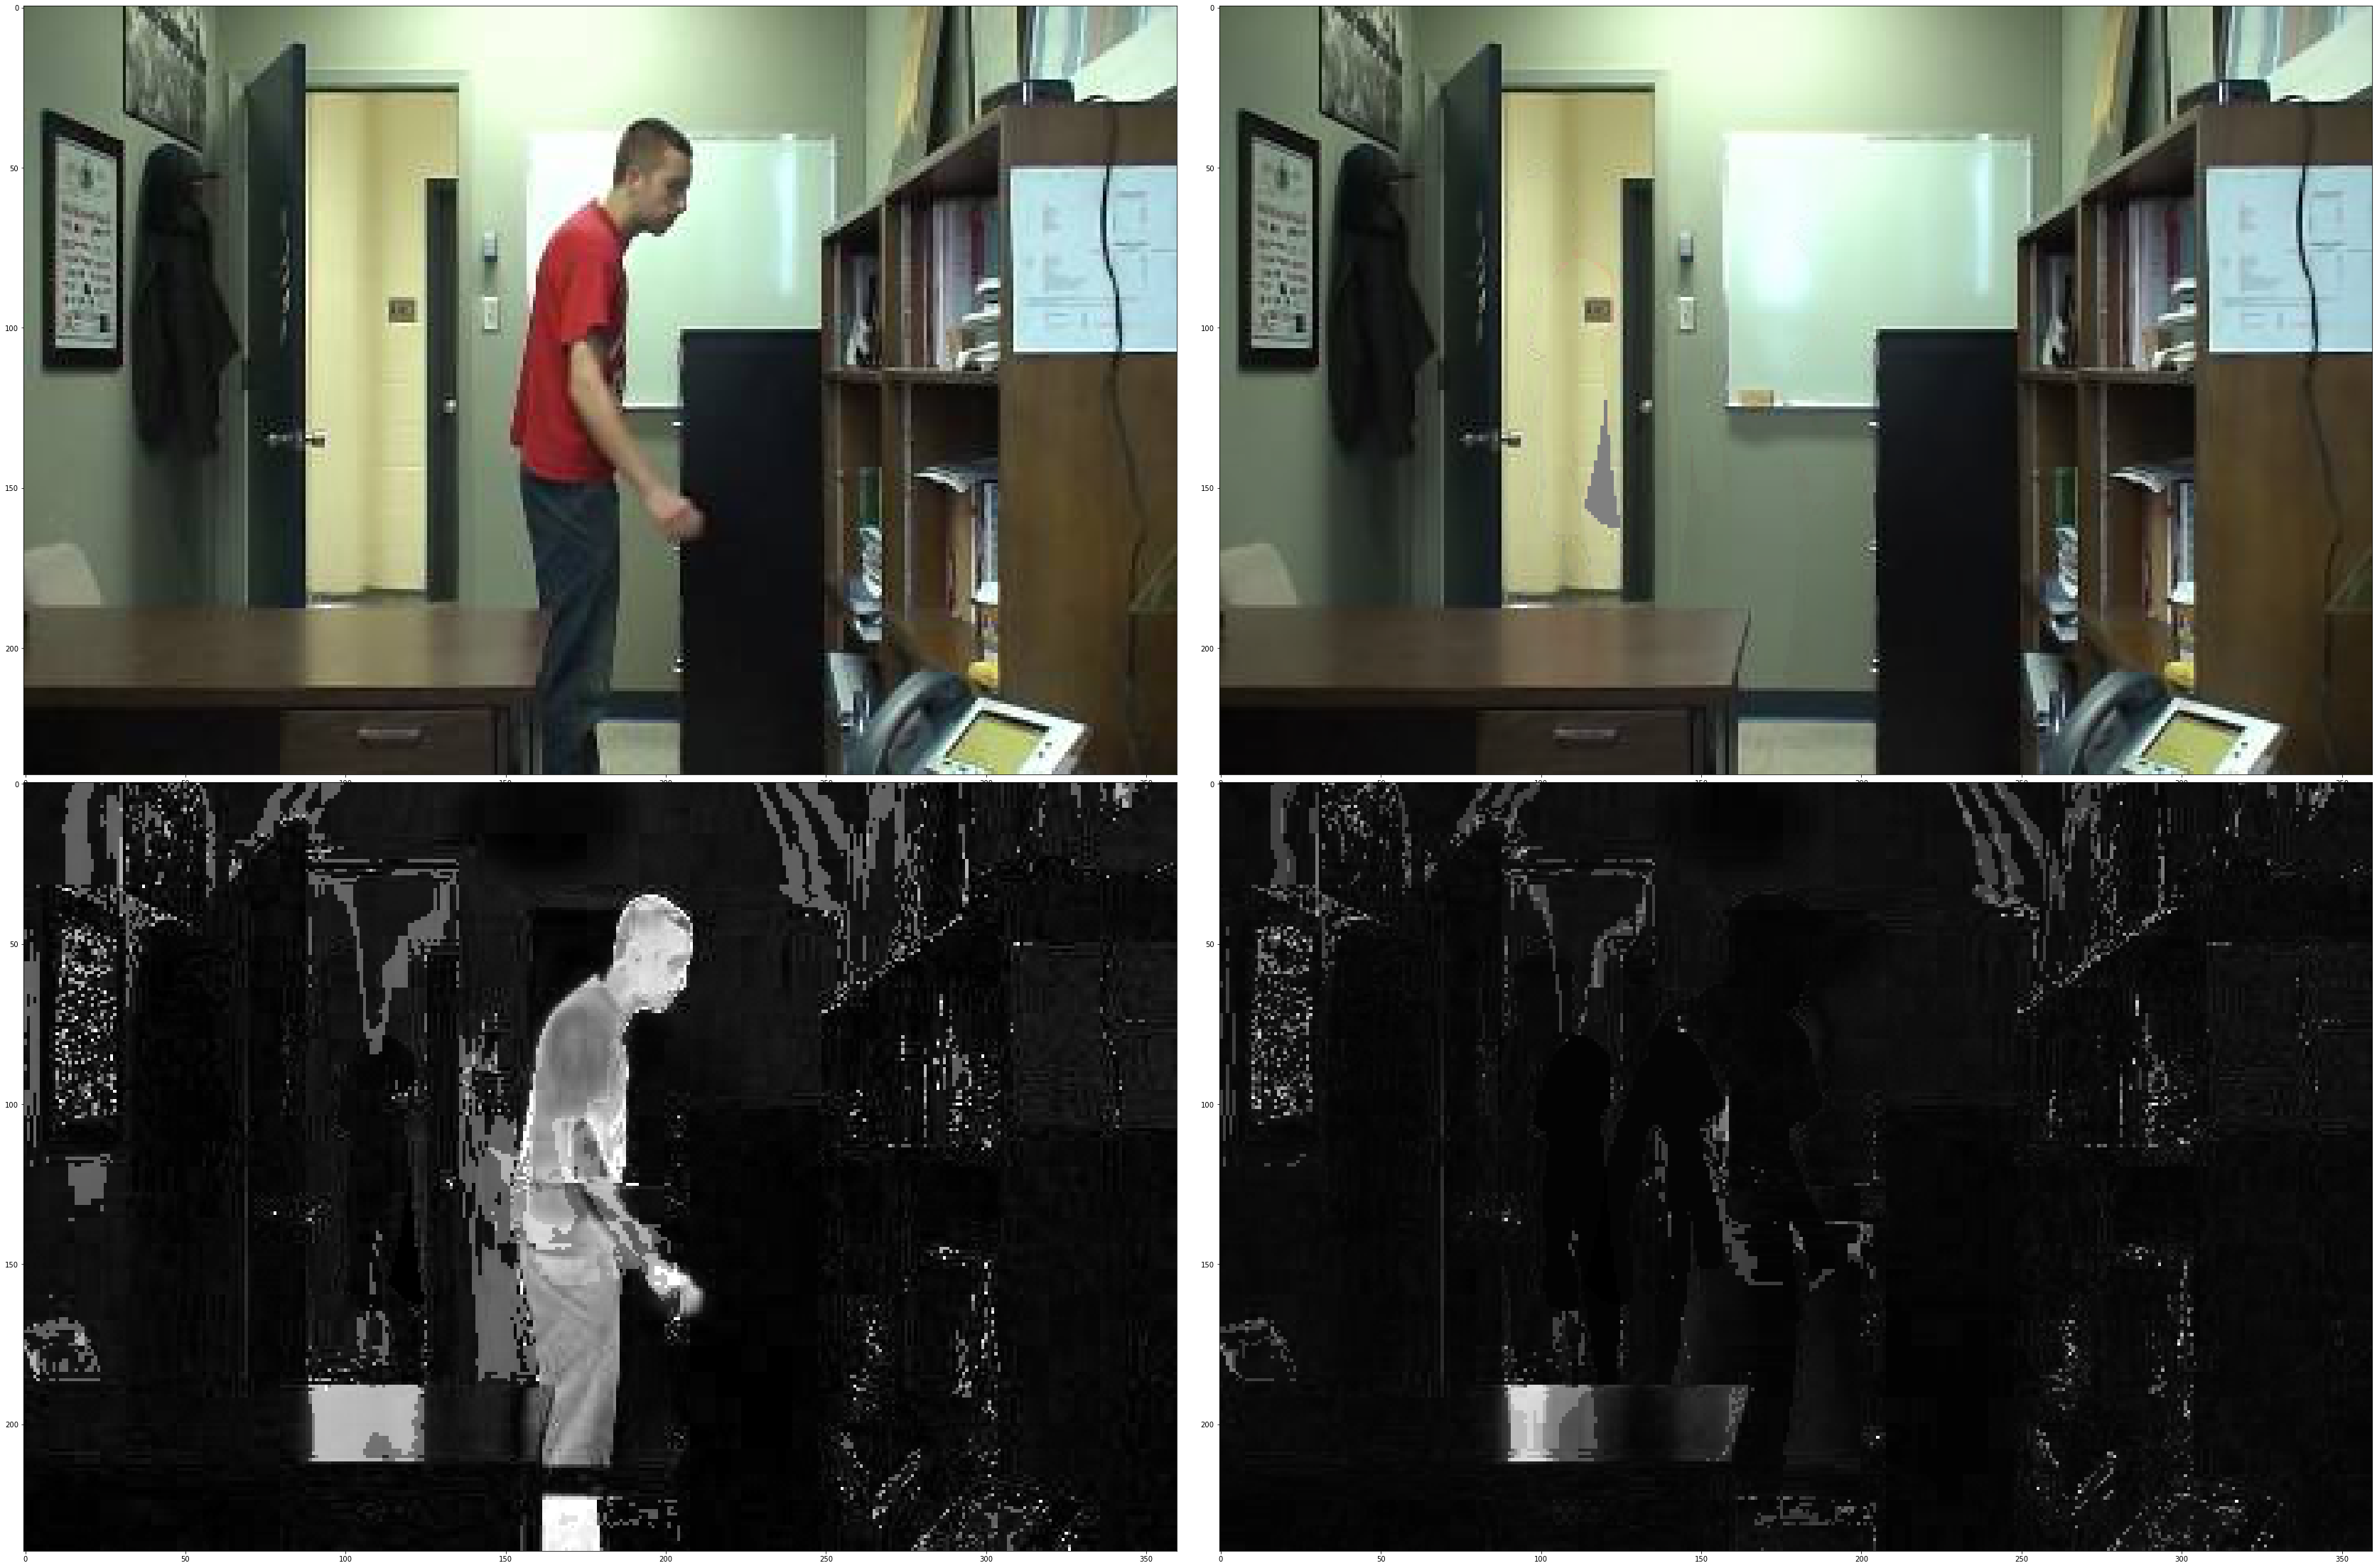

In [23]:
update_for_frame(model, 4)
show_model_for_frame(model, 5)

background_error <class 'imageio.core.util.Array'>
Shape: (240, 360), Type: float64, Min-max: (0.421875, 63.96875), Mean: 4.420453739872685


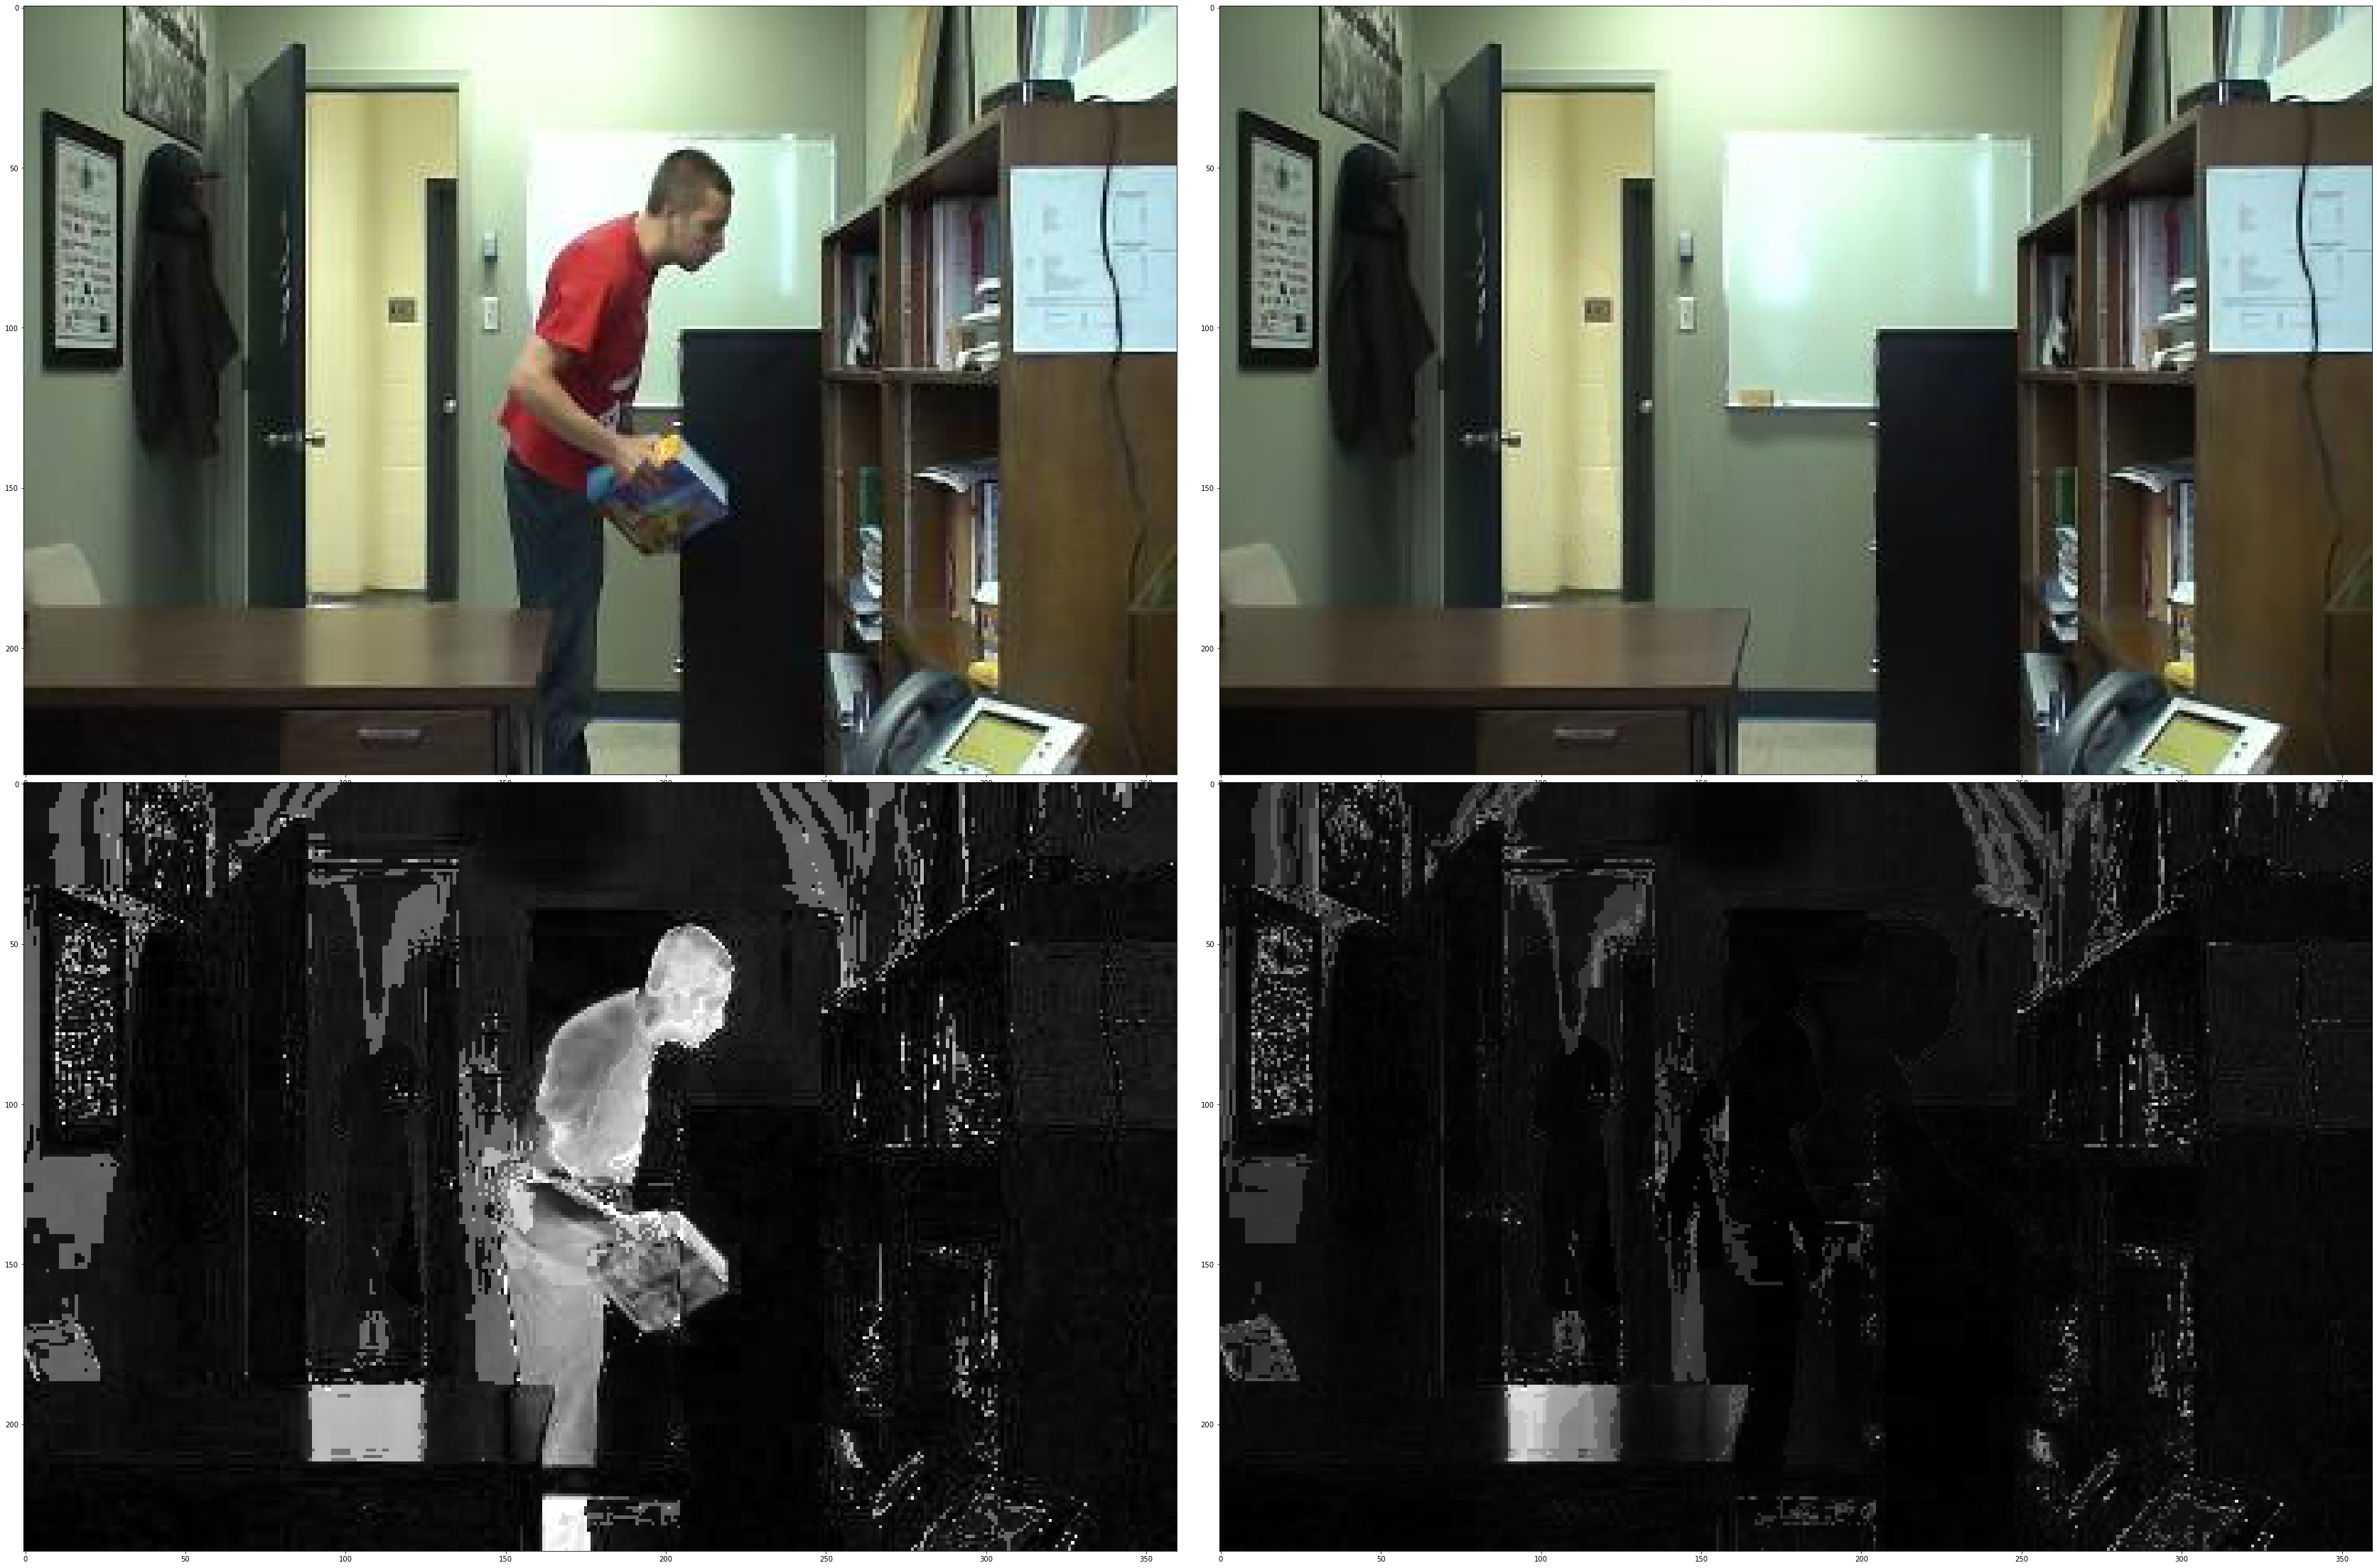

In [24]:
update_for_frame(model, 6)
show_model_for_frame(model, 8)

background_error <class 'imageio.core.util.Array'>
Shape: (240, 360), Type: float64, Min-max: (0.31640625, 70.0078125), Mean: 5.433635555314429


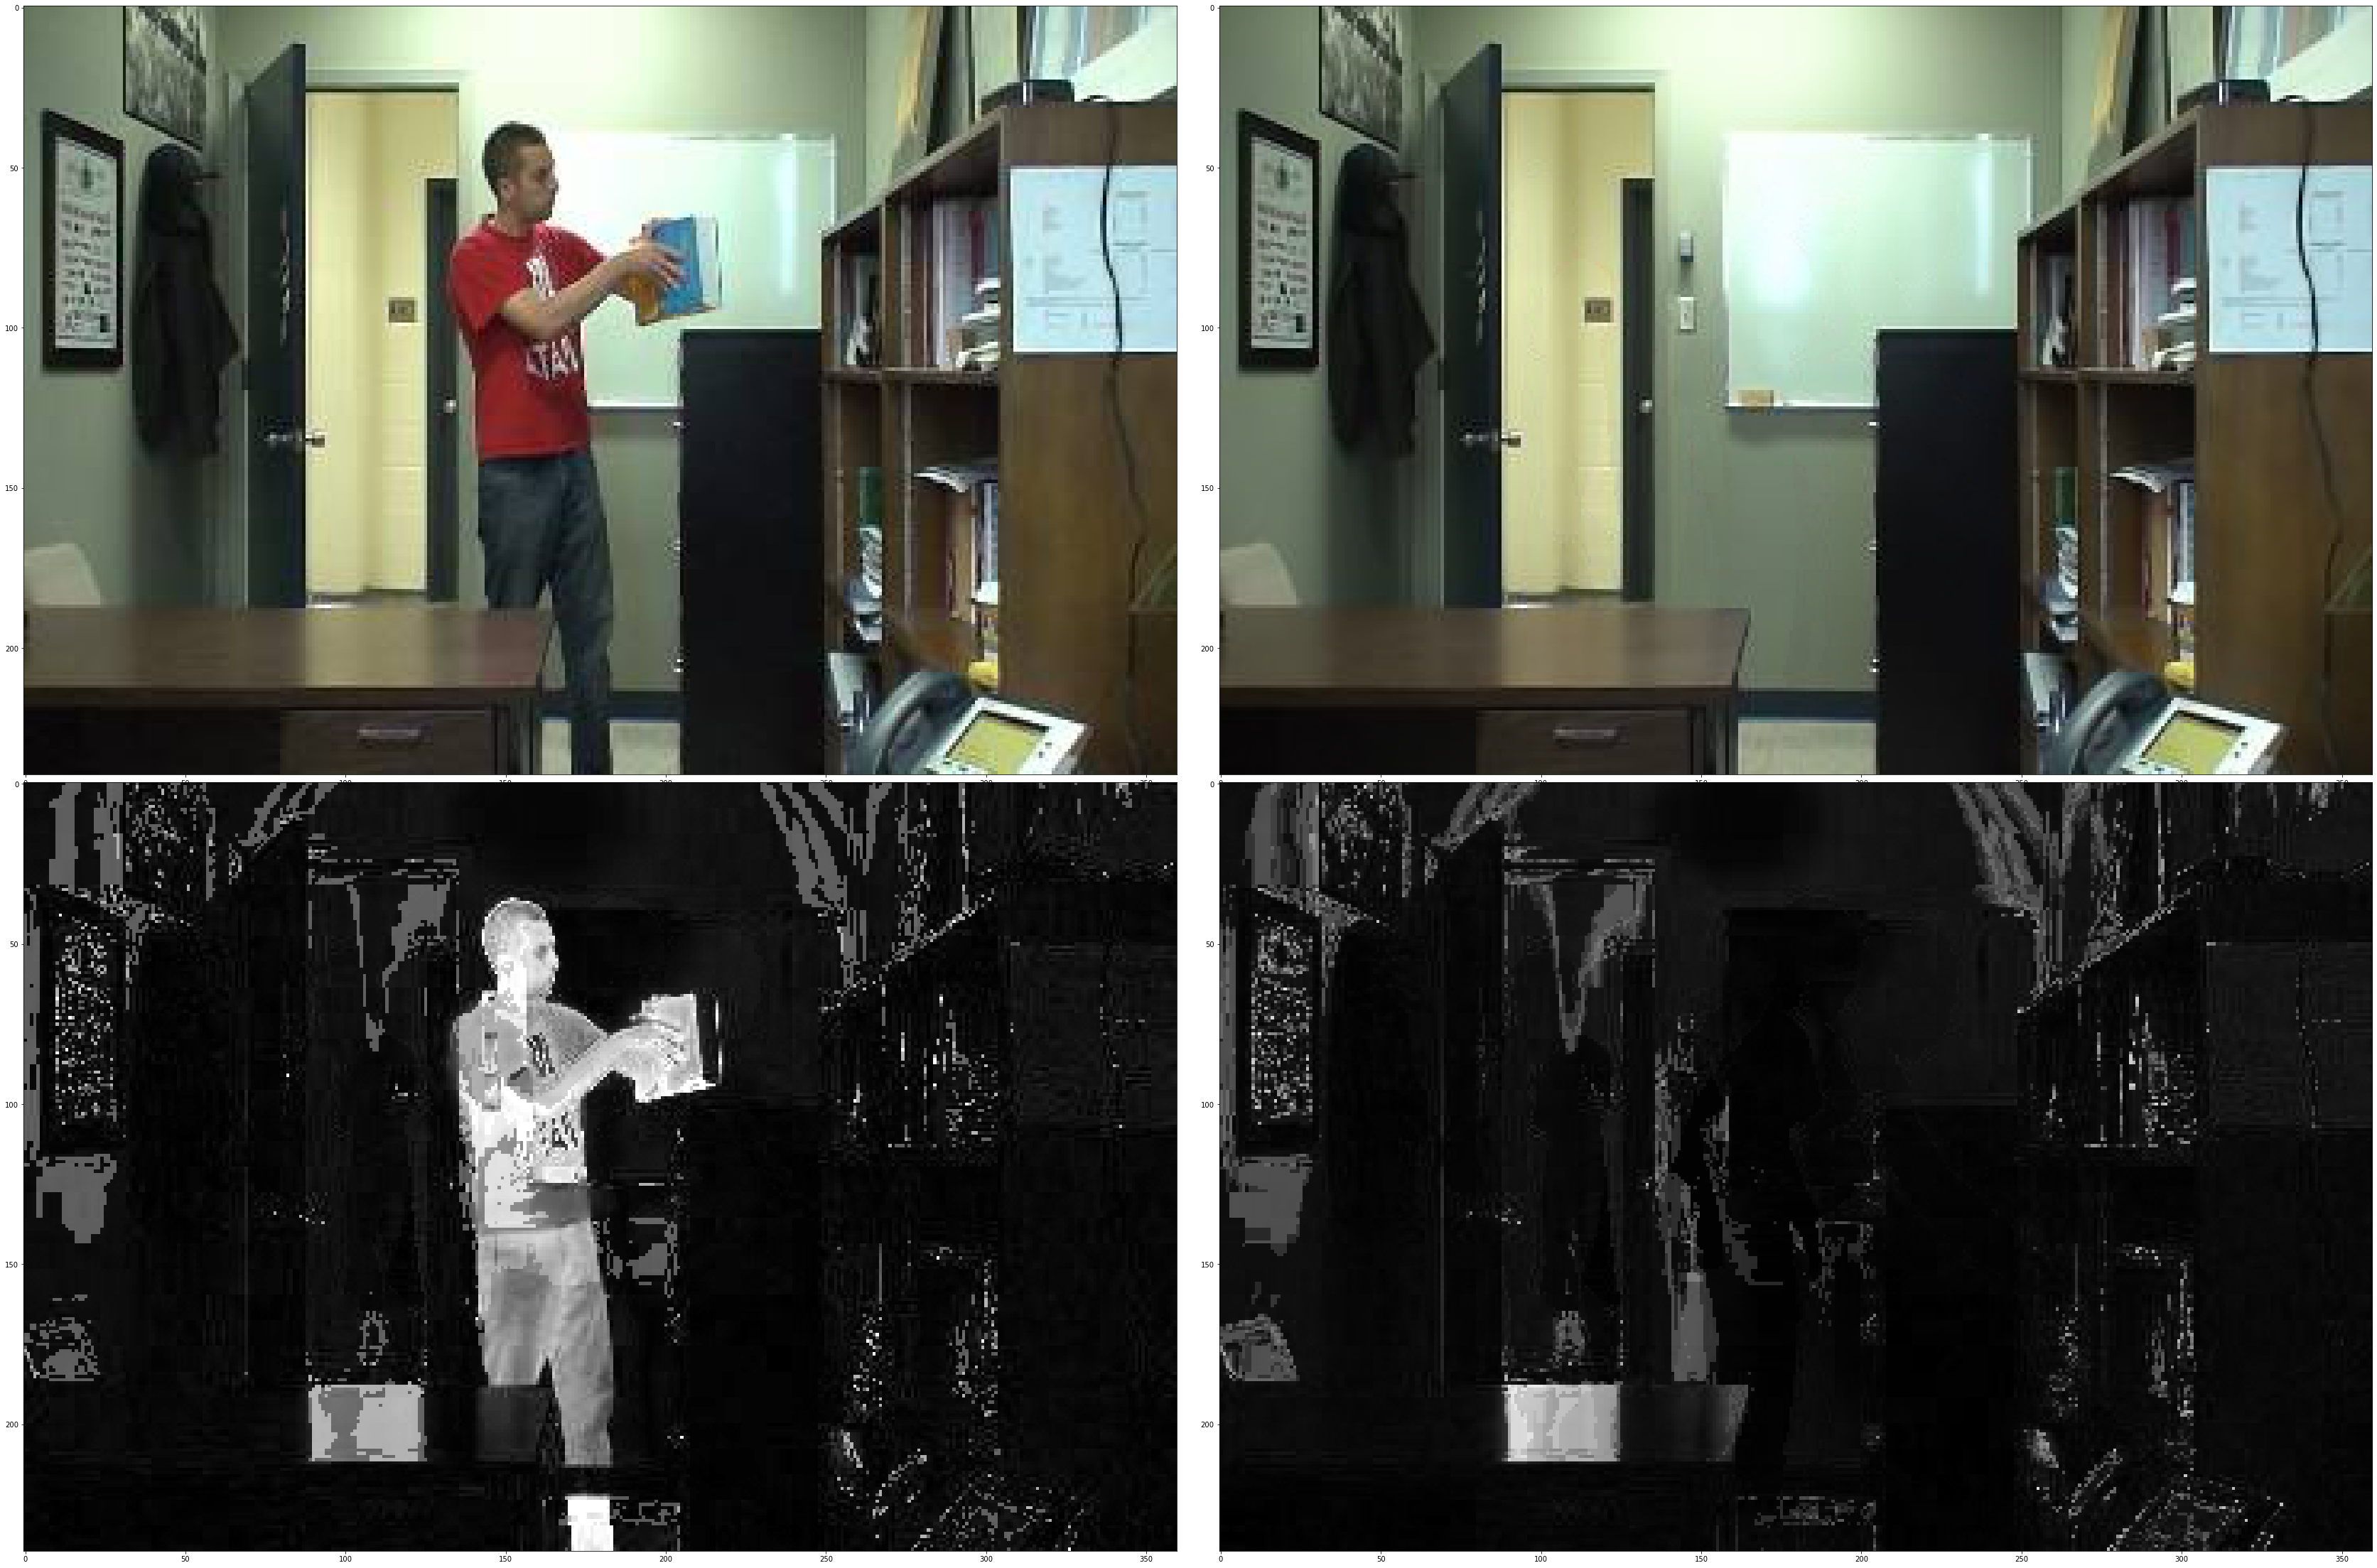

In [25]:
update_for_frame(model, 9)
show_model_for_frame(model, 11)